In [21]:
import gzip
from collections import defaultdict
import random
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn import linear_model
import numpy as np
import scipy

In [2]:
def readGz(path):
    for l in gzip.open(path, 'rt'):
        yield eval(l)

In [3]:
def readJSON(path):
    f = gzip.open(path, 'rt')
    f.readline()
    for l in f:
        d = eval(l)
        u = d['userID']
        g = d['gameID']
        yield u,g,d

In [5]:
allHours = []
for l in readJSON("../data/train.json.gz"):
    allHours.append(l)

In [7]:
##################################################
# Read prediction                                #
##################################################

In [11]:
# Utility data structures
reviewsPerUser = defaultdict(list)
reviewsPerGame = defaultdict(list)
usersPerGame = defaultdict(set) # U_i from class slides
gamesPerUser = defaultdict(set) # I_u from class slides
users = set() # all users
games = set() # all games

In [13]:
dataset = []

for user,game,d in readJSON("../data/train.json.gz"):
    dataset.append([user, game])
    reviewsPerUser[user].append(d)
    reviewsPerGame[game].append(d)
    usersPerGame[game].add(user)
    gamesPerUser[user].add(game)
    users.add(user)
    games.add(game)

In [14]:
X_train = dataset[:165000]
X_val = dataset[165000:]
y = [1]*len(dataset)
y_train = y[:165000]
y_val = y[165000:]

In [15]:
# Add negative entries to validation set

X_neg = []
for user, game in X_val:
    # sample negative entry by randomly hoosing a games that user hasn't played
    neg_game = random.sample(games.difference(gamesPerUser[user]), 1)
    X_neg.append([user, neg_game[0]])
y_neg = [0]*len(X_neg)

X_val.extend(X_neg)
y_val.extend(y_neg)

In [16]:
def Jaccard(s1, s2):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    if denom > 0:
        return numer/denom
    return 0

In [17]:
# Utility data structures
usersPerGame = defaultdict(set) # U_i from class slides
gamesPerUser = defaultdict(set) # I_u from class slides

In [18]:
for user, game in X_train:
    usersPerGame[game].add(user)
    gamesPerUser[user].add(game)

In [47]:
def predictPlaySim(user, game, threshold):
    '''
    Predicts would-play for a given user and game using Jaccard similarity metric.
    Looks at all training games that user u has played and computes the Jaccard similarity between g and g'.
    '''
    similarities = []
    for g in gamesPerUser[user]:
        # exclude if game is query
        if g == game: continue
            
        # add similarities
        similarities.append(Jaccard(usersPerGame[game], usersPerGame[g]))
    
    if len(similarities) == 0:
        return 0
    mean_sim = sum(similarities)/len(similarities)
    #print(mean_sim)
    if mean_sim > threshold:
        return 1
    else:
        return 0

In [75]:
# Once
userPlayPredictions = [predictPlaySim(u, g, 0.009) for u, g in X_val]
accuracy_score(y_val, userPlayPredictions)

0.7113711371137114

In [71]:
# Prediction using user-to-user similarity above for varying thresholds
thresh = np.linspace(0.009050, 0.009150, 50)
acc = []
for t in thresh:
    userPlayPredictions = [predictPlaySim(u, g, t) for u, g in X_val]
    acc.append(accuracy_score(y_val, userPlayPredictions))

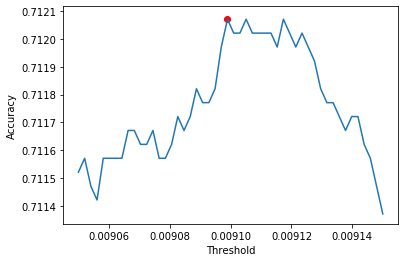

In [72]:
plt.plot(thresh, acc)
plt.scatter(thresh[acc.index(max(acc))], max(acc), color='red')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.show()

In [73]:
print("A threshold of {0} gives {1} accuracy.".format(round(thresh[acc.index(max(acc))], 10), max(acc)))

A threshold of 0.0090989796 gives 0.712071207120712 accuracy.


In [74]:
predictions = open("../submissions/would_play.csv", 'w')
for l in open("../data/pairs_Played.txt"):
    if l.startswith("userID"):
        #header
        predictions.write(l)
        continue
    u,g = l.strip().split('-')
    
    # make predictions
    predictions.write(u + '-' + g + ",{}\n".format(predictPlaySim(u, g, 0.009)))

predictions.close()

In [ ]:
#################################
# Classification using features #
#################################

In [100]:
# Add negative entries to training set
X_neg = []
for user, game in X_train:
    # sample negative entry by randomly hoosing a games that user hasn't played
    neg_game = random.sample(games.difference(gamesPerUser[user]), 1)
    X_neg.append([user, neg_game[0]])
y_neg = [0]*len(X_neg)

X_train.extend(X_neg)
y_train.extend(y_neg)

In [76]:
def meanSim(user, game):
    '''
    Gives mean similarity to of a certain game to all other games a user has 
    played using Jaccard similarity metric.
    '''
    similarities = []
    for g in gamesPerUser[user]:
        # exclude if game is query
        if g == game: continue
            
        # add similarities
        similarities.append(Jaccard(usersPerGame[game], usersPerGame[g]))
    
    if len(similarities) == 0:
        return 0
    mean_sim = sum(similarities)/len(similarities)
    
    return mean_sim

In [78]:
gameCount = defaultdict(int)
totalPlayed = 0

for user,game in X_train:
    gameCount[game] += 1
    totalPlayed += 1
    
mostPopular = [(gameCount[x], x) for x in gameCount]
mostPopular.sort()
mostPopular.reverse()   

In [91]:
def popularity(game):
    count = [elem[0] for i, elem in enumerate(mostPopular) if game in elem]
    if count == []:
        return 0
    else:
        return count[0]

In [95]:
def feat(u,g):
    return [popularity(g), meanSim(u, g)]

In [101]:
X_train_feat = [feat(u, g) for u, g in X_train]
X_val_feat = [feat(u, g) for u, g in X_val]

In [125]:
acc_c = []

for c in [0.00001, 0.1, 0.5, 1]:
    clf = linear_model.LogisticRegression(C=c, solver='lbfgs').fit(X_train_feat, y_train)
    yPred = clf.predict(X_val_feat)
    acc_c.append(accuracy_score(y_val, yPred))

In [126]:
acc_c

[0.6884688468846885,
 0.6907190719071907,
 0.6894689468946895,
 0.6866186618661866]

In [117]:
predictions = open("../submissions/would_play_clf.csv", 'w')
for l in open("../data/pairs_Played.txt"):
    if l.startswith("userID"):
        #header
        predictions.write(l)
        continue
    u,g = l.strip().split('-')
    
    # make predictions
    predictions.write(u + '-' + g + ",{}\n".format(clf.predict([feat(u,g)])[0]))

predictions.close()

In [112]:
feat('u42434461','b91625775')

[139, 0.01511080156152479]

In [115]:
clf.predict([[139, 0.01511080156152479]])[0]

1